In [18]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
from PIL import Image
import random
!pip install torchsummary
from torchsummary import summary
import zipfile
import shutil
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

In [19]:
# Use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


Files already downloaded and verified
Files already downloaded and verified


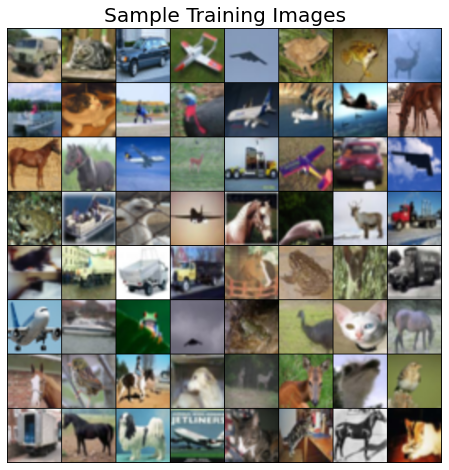

In [120]:
image_size = 64
batch_size = 64

data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

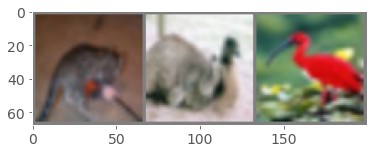

cat   bird  bird 


In [121]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(train_loader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show images
imshow(utils.make_grid(images[0:3]))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))

In [21]:
print('Training data')
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)} , {train_dataset.targets.count(2)}, {train_dataset.targets.count(3)}, {train_dataset.targets.count(4)} , {train_dataset.targets.count(5)} , {train_dataset.targets.count(6)}, {train_dataset.targets.count(7)}, {train_dataset.targets.count(8)}, {train_dataset.targets.count(9)}")
print(f"Samples:",len(train_dataset))

Training data
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Class count: 5000, 5000 , 5000, 5000, 5000 , 5000 , 5000, 5000, 5000, 5000
Samples: 50000


In [22]:
print('Validation data')
print(f"Classes: {valid_dataset.classes}")
print(f"Class count: {valid_dataset.targets.count(0)}, {valid_dataset.targets.count(1)} , {valid_dataset.targets.count(2)}, {valid_dataset.targets.count(3)}, {valid_dataset.targets.count(4)} , {valid_dataset.targets.count(5)} , {valid_dataset.targets.count(6)}, {valid_dataset.targets.count(7)}, {valid_dataset.targets.count(8)}, {valid_dataset.targets.count(9)}")
print(f"Samples:",len(valid_dataset))

Validation data
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Class count: 1000, 1000 , 1000, 1000, 1000 , 1000 , 1000, 1000, 1000, 1000
Samples: 10000


In [23]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    
    print('Training started:\n')
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    
    for epoch in range(epochs):  
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        
        train_loss.append(train_batch_loss / len(train_loader))
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():  
            for X, y in valid_loader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        
        valid_loss.append(valid_batch_loss / len(valid_loader))
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}")
    
    results = {"train_loss": train_loss,
               "train_accuracy": train_accuracy,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results

In [24]:
class cifar10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            
            nn.Conv2d(3, 32, (3, 3) ,padding=1),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, (3, 3) ,padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.3),
            
            nn.Conv2d(32, 64, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.BatchNorm2d(128),
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 256, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.BatchNorm2d(256),
            nn.Dropout(0.3),
            
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        
        )
        
        
    def forward(self, x):
        out = self.main(x)
        return out

In [122]:
model = cifar10_CNN()
model.to(device)
summary(model,(3,image_size, image_size));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,248
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
          Dropout-11           [-1, 64, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]          73,856
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
results = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=30)

Training started:

Epoch 1: Train Loss: 1.700 Train Accuracy: 0.38 Valid Loss: 1.951. Valid Accuracy: 0.34
Epoch 2: Train Loss: 1.256 Train Accuracy: 0.54 Valid Loss: 1.909. Valid Accuracy: 0.40
Epoch 3: Train Loss: 1.056 Train Accuracy: 0.62 Valid Loss: 1.581. Valid Accuracy: 0.49
Epoch 4: Train Loss: 0.927 Train Accuracy: 0.67 Valid Loss: 1.283. Valid Accuracy: 0.57
Epoch 5: Train Loss: 0.833 Train Accuracy: 0.70 Valid Loss: 1.199. Valid Accuracy: 0.61
Epoch 6: Train Loss: 0.762 Train Accuracy: 0.73 Valid Loss: 1.203. Valid Accuracy: 0.62
Epoch 7: Train Loss: 0.705 Train Accuracy: 0.75 Valid Loss: 0.969. Valid Accuracy: 0.68
Epoch 8: Train Loss: 0.653 Train Accuracy: 0.77 Valid Loss: 0.953. Valid Accuracy: 0.69
Epoch 9: Train Loss: 0.614 Train Accuracy: 0.78 Valid Loss: 0.835. Valid Accuracy: 0.72
Epoch 10: Train Loss: 0.571 Train Accuracy: 0.80 Valid Loss: 0.805. Valid Accuracy: 0.73
Epoch 11: Train Loss: 0.541 Train Accuracy: 0.81 Valid Loss: 0.909. Valid Accuracy: 0.71
Epoch 12: T

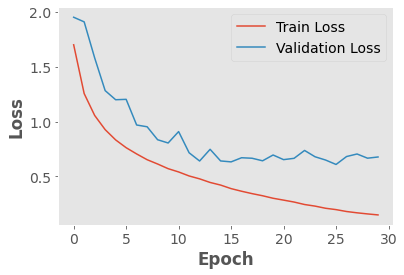

In [73]:
plt.plot(np.array(results['train_loss']), label='Train Loss')
plt.plot(np.array(results['valid_loss']), label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

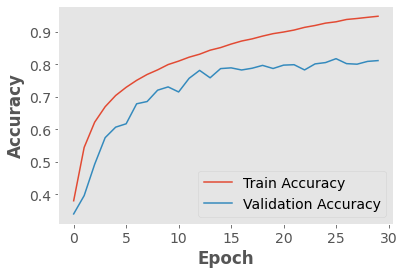

In [74]:
plt.plot(np.array(results['train_accuracy']), label='Train Accuracy')
plt.plot(np.array(results['valid_accuracy']), label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();